# 1)

### 1.1) pip install tensorflow opencv-python

In [1]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
#tensorflow dependencies -functional api
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [3]:
#avoid OOM(out of memory) errors by setting GPU memory consumptioni Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
#paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [5]:
POS_PATH


'data\\positive'

In [31]:
# Make the directories (NR)
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

# 2)

### 2.1)

In [9]:
# https://www.kaggle.com/datasets/jessicali9530/lfw-dataset

In [10]:
# To Uncompress Tar GZ Labelled Dataset
#!tar -xf filename.tgz

In [11]:
#For this project I downloaded data set from kaggle but the folder in IFW-deepfunneled contains all the require data.

In [32]:
# Move LFW Images to the following repository data/negative (NR)
for directory in os.listdir('lfw-deepfunneled'):
    for file in os.listdir(os.path.join('lfw-deepfunneled', directory)):
        EX_PATH = os.path.join('lfw-deepfunneled', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'lfw-deepfunneled'

### 2.2)

In [6]:
# Import uuid library to generate unique image names
import uuid

In [34]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\9fe057f0-a559-11f0-9078-4c82a97a4eca.jpg'

In [22]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

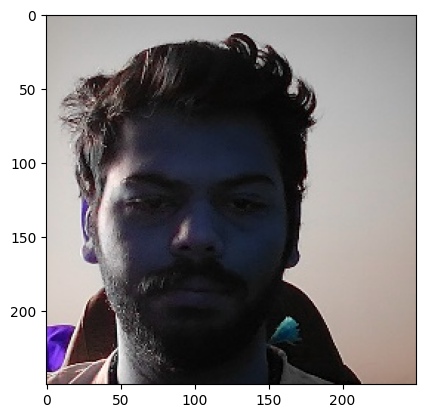

In [38]:
plt.imshow(frame)


# 3)

### 3.1)

In [7]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)

In [8]:
dir_test = anchor.as_numpy_iterator()

In [9]:
print(dir_test.next())

b'data\\anchor\\44f24bd9-a55a-11f0-af5c-4c82a97a4eca.jpg'


### 3.2)

In [10]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [11]:
img = preprocess('data\\anchor\\4aad18d8-a55a-11f0-99ad-4c82a97a4eca.jpg')

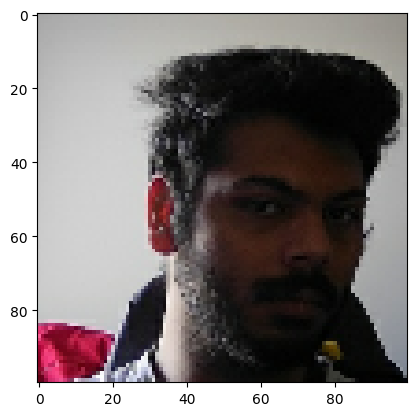

In [12]:
plt.imshow(img)

In [16]:
img.numpy().max() 

np.float32(1.0)

### 3.3)

In [13]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [14]:
samples = data.as_numpy_iterator()

In [15]:
example = samples.next()

In [16]:
example

(b'data\\anchor\\4dec0444-a55a-11f0-8fd0-4c82a97a4eca.jpg',
 b'data\\positive\\d87b7d86-a55a-11f0-8dc8-4c82a97a4eca.jpg',
 np.float32(1.0))

### 3.4)

In [17]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [18]:
res = preprocess_twin(*example)

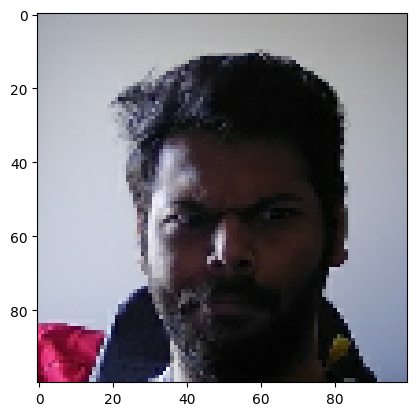

In [19]:
plt.imshow(res[1])

In [20]:
res[2]

np.float32(1.0)

In [59]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [21]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [22]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4

### 4.1

In [23]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [24]:
embedding = make_embedding()

In [26]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

### 4.2

In [27]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

    def compute_output_shape(self, input_shape):
        return (input_shape[0])

### 4.3

In [28]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [29]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [30]:
siamese_layer = L1Dist()

In [31]:
distances = siamese_layer(inp_embedding, val_embedding)

In [32]:
classifier = Dense(1, activation='sigmoid')(distances)

In [33]:
classifier

<KerasTensor shape=(None, 1), dtype=float32, sparse=False, ragged=False, name=keras_tensor_12>

In [34]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [35]:
siamese_network.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist (L1Dist)    │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      4,097 │ l1_dist[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [37]:
siamese_model = make_siamese_model()

In [38]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_1 (L1Dist)  │ (None, 4096)      │          0 │ embedding[2][0],  │
│                     │                   │            │ embedding[3][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

# 5

### 5.1

In [39]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [40]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

### 5.2

In [41]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

### 5.3

In [68]:
test_batch = train_data.as_numpy_iterator()

In [69]:
batch_1 = test_batch.next()

In [70]:
batch_1[2]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
      dtype=float32)

In [73]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)   
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

### 5.4

In [74]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [75]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

### 5.5

In [76]:
EPOCHS = 50

In [77]:
train(train_data, EPOCHS)


 Epoch 1/50


ValueError: in user code:

    File "C:\Users\meetp\AppData\Local\Temp\ipykernel_20352\884425786.py", line 12, in train_step  *
        yhat = siamese_model(X, training=True)
    File "C:\python3139\Lib\site-packages\keras\src\utils\traceback_utils.py", line 122, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "C:\python3139\Lib\site-packages\keras\src\models\functional.py", line 276, in _adjust_input_rank
        raise ValueError(

    ValueError: Exception encountered when calling Functional.call().
    
    [1mInvalid input shape for input Tensor("SiameseNetwork_1/Cast:0", shape=(16,), dtype=float32). Expected shape (None, 100, 100, 3), but input has incompatible shape (16,)[0m
    
    Arguments received by Functional.call():
      • inputs=('tf.Tensor(shape=(16,), dtype=string)', 'tf.Tensor(shape=(16,), dtype=string)')
      • training=True
      • mask=('None', 'None')
      • kwargs=<class 'inspect._empty'>


# 6

### 6.1

In [ ]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

### 6.2

In [ ]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [ ]:
y_hat = siamese_model.predict([test_input, test_val])

In [ ]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

In [ ]:
y_true

### 6.3

In [ ]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

In [ ]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

In [ ]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

### 6.4

In [ ]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

# 7 

In [ ]:
# Save weights
siamese_model.save('siamesemodelv2.h5')

In [ ]:
L1Dist

In [ ]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [ ]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

In [ ]:
# View model summary
siamese_model.summary()

# 8

### 8.1

In [ ]:
application_data\verification_images

In [ ]:
os.listdir(os.path.join('application_data', 'verification_images'))

In [ ]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

In [ ]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

In [ ]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

### 8.2

In [ ]:
cap = cv2.VideoCapture(4)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
#         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#         h, s, v = cv2.split(hsv)

#         lim = 255 - 10
#         v[v > lim] = 255
#         v[v <= lim] -= 10
        
#         final_hsv = cv2.merge((h, s, v))
#         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [ ]:
np.sum(np.squeeze(results) > 0.9)

In [ ]:
results

# END